In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
df = pd.read_csv('Phishing Websites Engineered.csv')

# Features and target
X = df.drop(columns='target')
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [3]:
y_pred1 = naive_bayes.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Accuracy: 0.717948717948718
              precision    recall  f1-score   support

          -1       0.65      1.00      0.79       620
           1       0.99      0.41      0.57       550

    accuracy                           0.72      1170
   macro avg       0.82      0.70      0.68      1170
weighted avg       0.81      0.72      0.69      1170



  0%|          | 0/10 [00:00<?, ?it/s]

🔍 SHAP Summary Plot - Naive Bayes


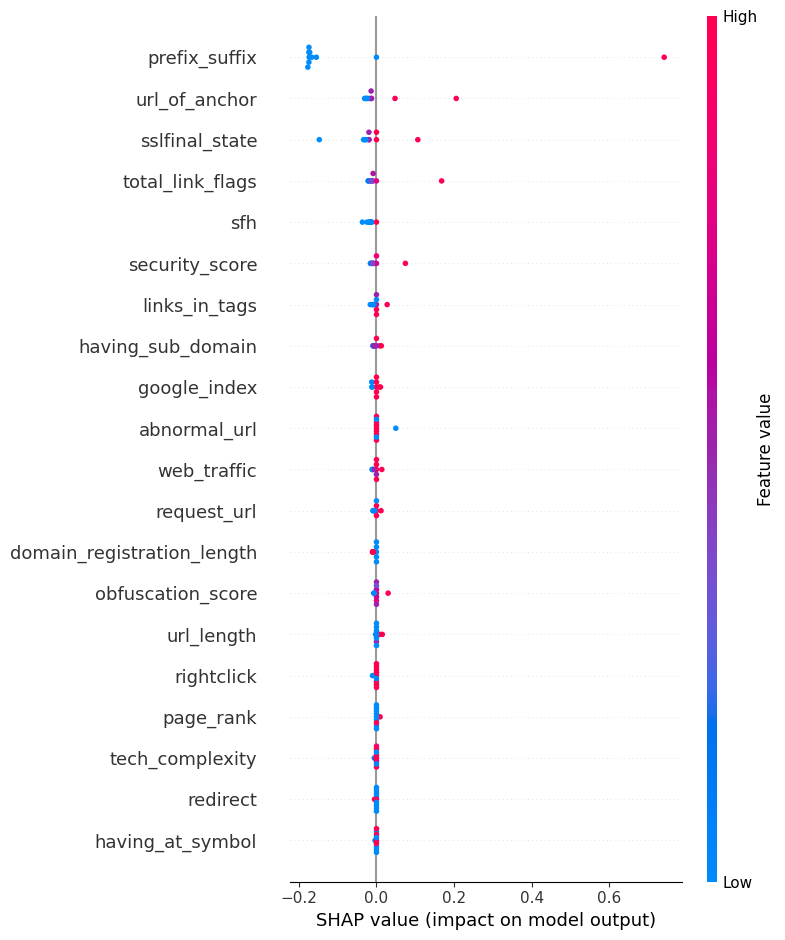

In [7]:
import shap
# Sample background data for SHAP (100 samples for efficiency)
background = shap.sample(X_train, 100, random_state=42)

# Create SHAP KernelExplainer for Naive Bayes
nb_explainer = shap.KernelExplainer(naive_bayes.predict_proba, background)

# Pick a few test instances
sample = X_test.sample(10, random_state=42)

# Compute SHAP values
nb_shap_values = nb_explainer.shap_values(sample)

# For binary classification, select SHAP values for the positive class (index 1)
# For multiclass, you may need to loop through each class or select one
if isinstance(nb_shap_values, list):
    nb_shap_values = nb_shap_values[1]
elif len(nb_shap_values.shape) == 3:
    nb_shap_values = nb_shap_values[:, :, 1]

# Visualize SHAP summary plot
print("🔍 SHAP Summary Plot - Naive Bayes")
shap.summary_plot(nb_shap_values, sample, feature_names=X_train.columns, show=False)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Explicitly display the plot

In [8]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=390592c9c66aa54b338c9c08ed3269c518c22cd81c5b83a3b5061ce273225cea
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [9]:
import lime
import lime.lime_tabular
import numpy as np


In [10]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)

In [11]:
def explain_instance_lime(model, model_name):
    i = np.random.randint(0, X_test.shape[0])
    exp = lime_explainer.explain_instance(
        X_test.iloc[i],
        model.predict_proba,
        num_features=10
    )
    print(f"\n🔍 LIME Explanation for model: {model_name} on instance {i}")
    exp.show_in_notebook(show_table=True)
    return exp

In [12]:
# Explain one instance with each model
explain_instance_lime(naive_bayes, "Naive Bayes")

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


🔍 LIME Explanation for model: Naive Bayes on instance 861


Top 5 Features by PFI:
             Feature  Importance
5      prefix_suffix    0.100171
7     sslfinal_state    0.026068
13     url_of_anchor    0.021111
30  total_link_flags    0.016496
15               sfh    0.015385


<Figure size 1000x600 with 0 Axes>

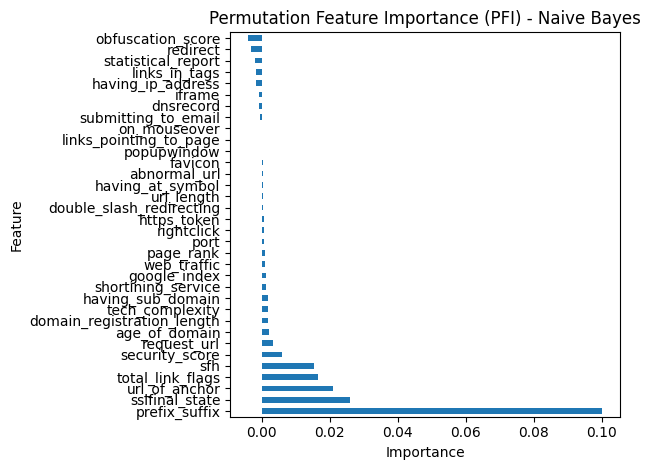

In [13]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib.pyplot as plt

pfi_result = permutation_importance(naive_bayes, X_test, y_test, n_repeats=10, random_state=42)

pfi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Top 5 Features by PFI:")
print(pfi_df.head())

plt.figure(figsize=(10, 6))
pfi_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Permutation Feature Importance (PFI) - Naive Bayes")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# PDP & ICE

Feature prefix_suffix has 2 unique values: [-1  1]
Feature sslfinal_state has 3 unique values: [ 0 -1  1]
Feature url_of_anchor has 3 unique values: [-1  0  1]
Feature total_link_flags has 9 unique values: [ 1 -1  2 -2  0  3 -3  4 -4]
Feature sfh has 3 unique values: [-1  1  0]


<ipython-input-14-10f8182a58fe>:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


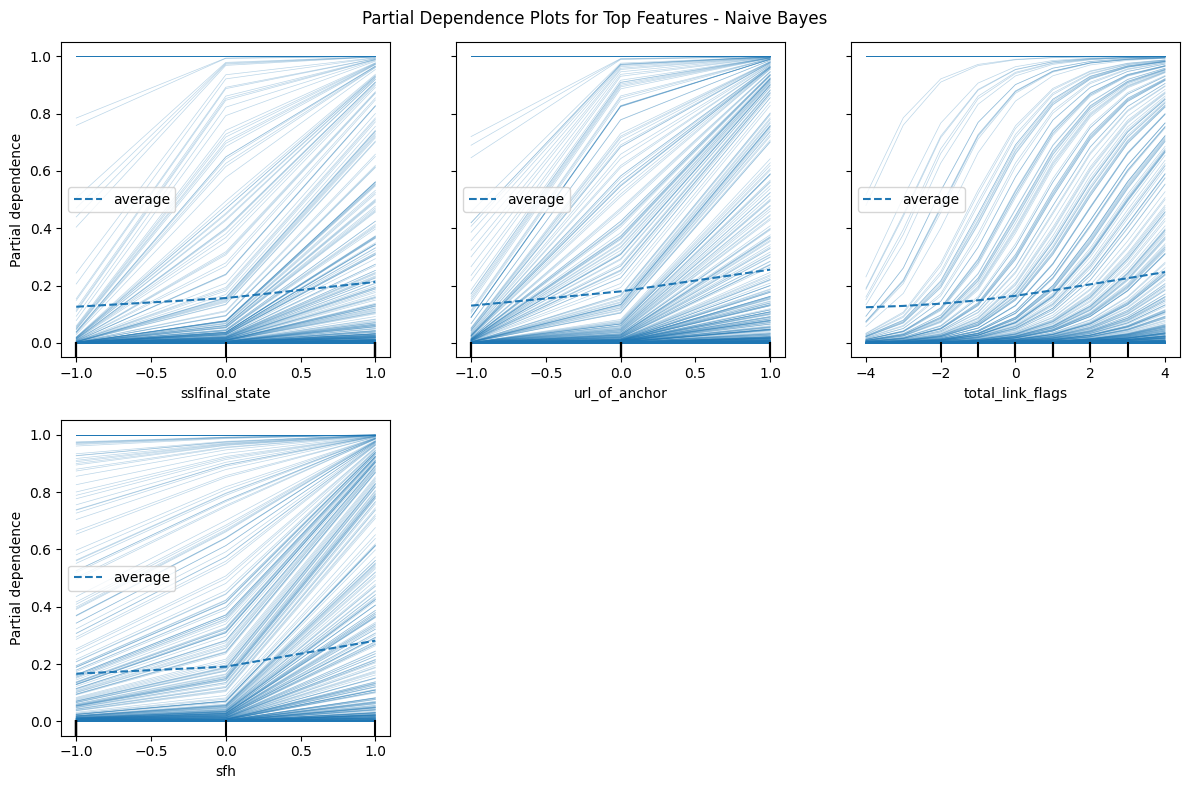

In [14]:
top_features = pfi_df['Feature'].head(5).tolist()

suitable_features = []
for feature in top_features:
    unique_values = X_test[feature].nunique()
    print(f"Feature {feature} has {unique_values} unique values: {X_test[feature].unique()}")
    if unique_values > 2:
        suitable_features.append(feature)

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    naive_bayes,
    X_test,
    features=suitable_features,
    grid_resolution=10,
    kind ="both",
    ax=ax
)
plt.suptitle("Partial Dependence Plots for Top Features - Naive Bayes")
plt.tight_layout()
plt.show()